In [1]:
# Create a Simulate Environment

# Imports

In [62]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import librosa
import torchaudio.transforms as T
import os



%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')

from environment import LinearArray
from audio_datasets import YesNoDataset
from beamformer import DAS_beamformer,MVDR_beamformer, apply_beamformer, get_directivity

# Test the Beamforming Environment

In [ ]:
audio_path = '/home/ms4/Desktop/research/beamforming/waves_yesno/0_0_0_0_1_1_1_1.wav'
signal, sample_rate = librosa.load(audio_path, sr=None) #sr=None preserves original sample rate

print(sample_rate)
plt.plot(signal)

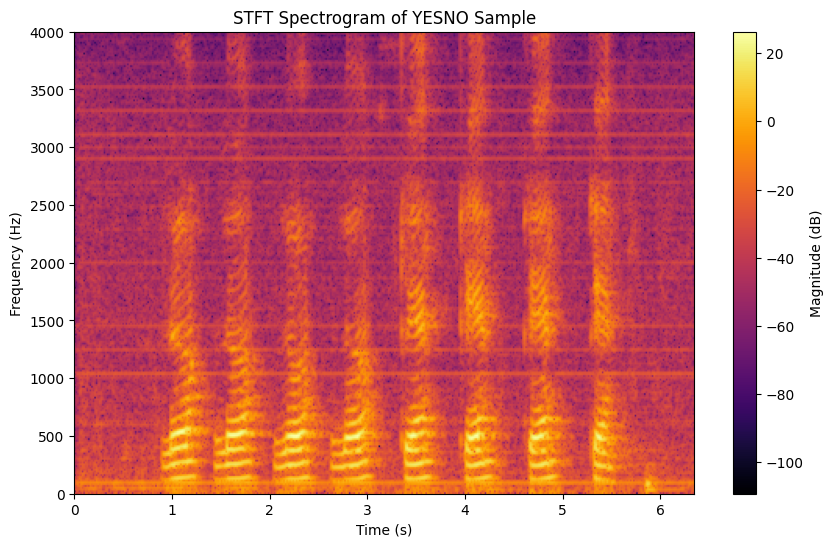

In [ ]:
# Define STFT parameters
n_fft = 512
win_length = 512
hop_length = 128

# Compute STFT
stft_transform = T.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=None)
spectrogram = stft_transform(torch.tensor(signal))  # Shape: (num_channels, num_freq_bins, num_time_frames)

# Convert to magnitude spectrogram
magnitude = spectrogram.abs().squeeze(0)  # Remove channel dim if mono

# Plot spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(20 * torch.log10(magnitude + 1e-6).numpy(), aspect='auto', origin='lower', cmap='inferno', 
           extent=[0, signal.shape[-1] / sample_rate, 0, sample_rate / 2])
plt.colorbar(label="Magnitude (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("STFT Spectrogram of YESNO Sample")
plt.show()

In [247]:
# APPLY SHIFTS TO 

M = 8
N = spectrogram.shape[1]
Nf = spectrogram.shape[0]
theta = torch.tensor(30)
c = 343

d = 0.2
sample_rate = 8000

# f and t axis for spectrogram
t_axis = torch.linspace(0, signal.shape[0] , steps=N)
f_axis = torch.linspace(0, sample_rate/2, steps=Nf)

# (M,Nf,N)
# STEERING VECTOR
# Arr Position (M,1)
pos = torch.tensor([i*d for i in range(M)]).view(-1,1)
tau = -(pos * torch.sin(torch.deg2rad(theta)))/c # (M,1)
phi = 2*np.pi*tau @ f_axis.view(1,-1) # (M,Nf)
s_vec = torch.exp(1j*phi)

# Apply product to the spectrogram (Nf,N)
shifted_spectrogram = s_vec.unsqueeze(-1) * spectrogram.unsqueeze(0)
    

f,ax = plt.subplots(1,1,figsize=(10,6))

ax.imshow(torch.angle(s_vec),extent=[f_axis[0],f_axis[-1],0,M],aspect='auto')
ax.set_title('Wrapped Phase delay')
ax.set_ylabel('Array Index')
ax.set_xlabel('Frequency (Hz)')

NameError: name 'spectrogram' is not defined

In [248]:
linear_array()

NameError: name 'linear_array' is not defined

In [249]:
inv_spectrogram_transform =  T.InverseSpectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length)
X = inv_spectrogram_transform(shifted_spectrogram)

NameError: name 'n_fft' is not defined

(10000.0, 10050.0)

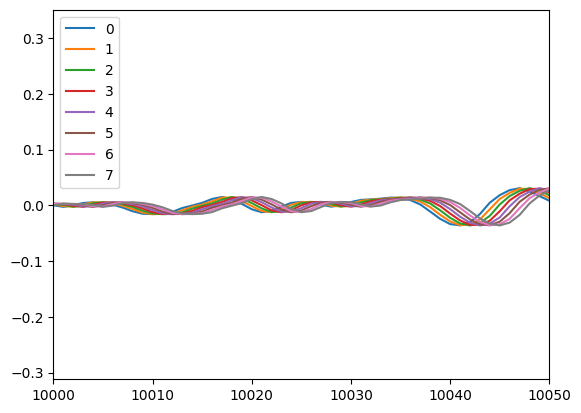

In [180]:
for i in range(M):
    plt.plot(X[i,:])
plt.legend([str(i) for i in range(M)])
plt.xlim(10000,10050)

In [5]:
dataset = YesNoDataset(audio_path='./waves_yesno')

## Linear Array

In [257]:
M = 20
L = 2000
d = 0.1
fs = 8000
lin_arr = LinearArray(M,L,d,fs)
print(lin_arr.__len__())

0


In [258]:
# Load signal
s1 = torch.tensor(dataset[6][0][:L])
s2 = torch.tensor(dataset[35][0][:L])

lin_arr.add_signal(s1.view(1,-1),theta=67)
#lin_arr.add_signal(s2.view(1,-1),theta=90)

In [259]:
# Read Sensor
X = lin_arr.read_sensor()

(0.0, 600.0)

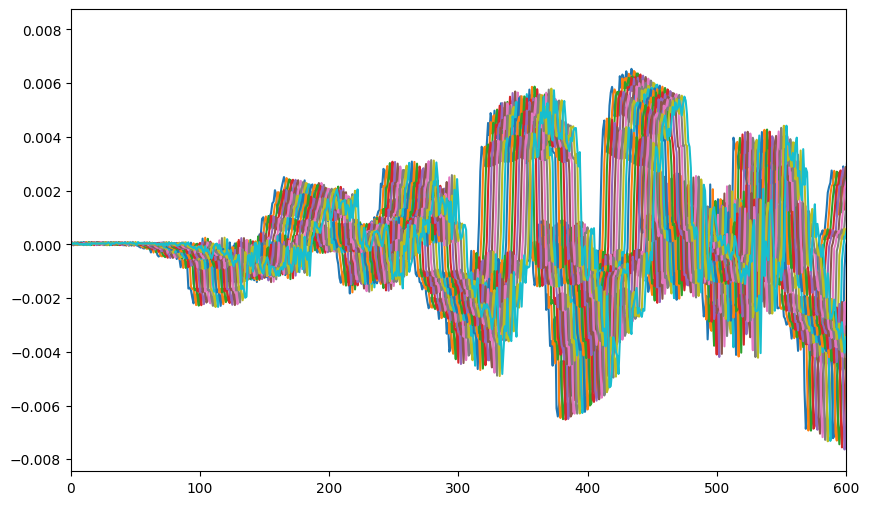

In [260]:
f,ax = plt.subplots(figsize=(10,6))
for i in range(M):
    ax.plot(X[i,:])

ax.set_xlim([0,600])
#ax.set_title('Multi-sensor Output')


In [261]:
# Apply DAS
das = DAS_beamformer(lin_arr=lin_arr, theta_target=67)

output_signal = apply_beamformer(X,das)

torch.Size([20, 100, 257]) torch.Size([257, 20])
torch.Size([257, 20])


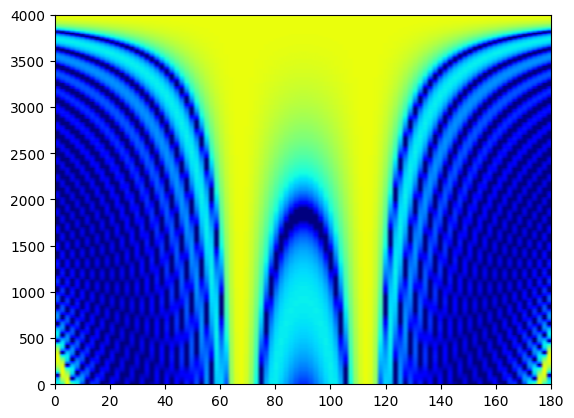

In [262]:
# get directivity
D = torch.log(get_directivity(lin_arr,das,n_thetas=100)+1e-2)
print(das.shape)
plt.imshow(D.transpose(-1,-2),aspect='auto',extent=[0,180,0,fs/2], clim=(-1,10),cmap = 'jet')

Text(0.5, 1.0, 'DAS Output')

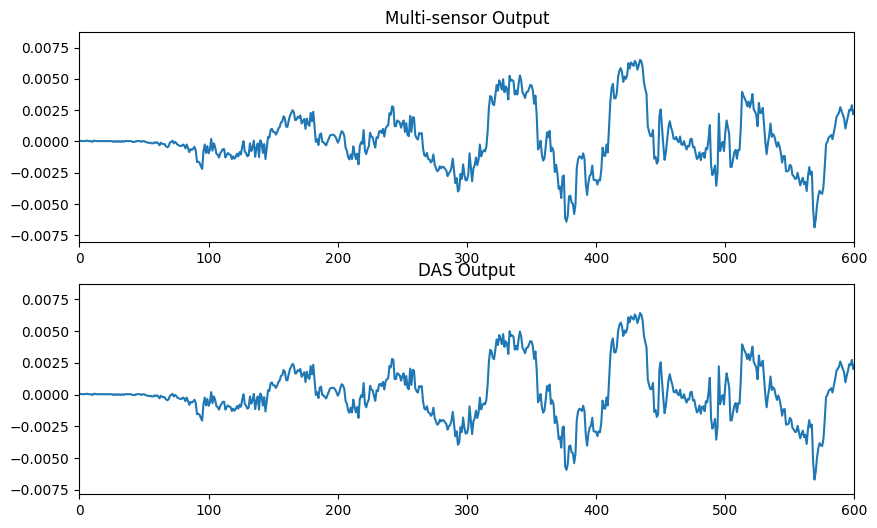

In [263]:
f,ax = plt.subplots(2,1,figsize=(10,6))
#for i in range(M):
   #ax[0].plot(X[i,:])

ax[0].plot(s1)
ax[1].plot(output_signal)


ax[0].set_xlim([0,600])
ax[1].set_xlim([0,600])


ax[0].set_title('Multi-sensor Output')
ax[1].set_title('DAS Output')

## MVDR

torch.Size([20, 100, 257]) torch.Size([257, 20])
torch.Size([257, 20])


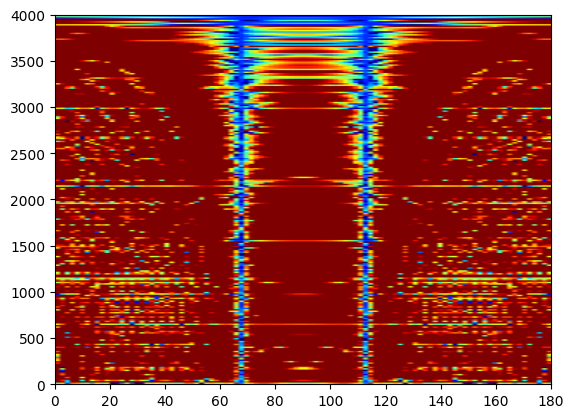

In [268]:
w = MVDR_beamformer(lin_arr,67)
# get directivity
D = torch.log(get_directivity(lin_arr,w,n_thetas=100))
print(w.shape)
plt.imshow(D.transpose(-1,-2),aspect='auto',extent=[0,180,0,fs/2], clim=(-1,5),cmap = 'jet')

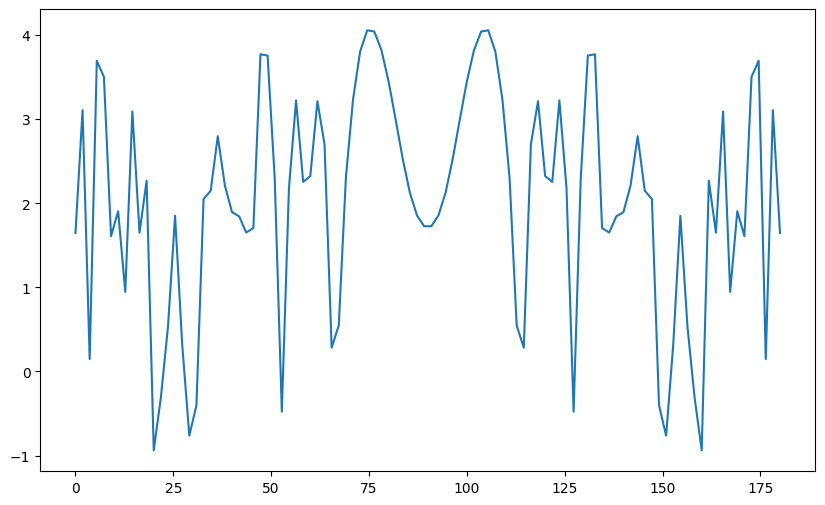

In [265]:
f,ax = plt.subplots(figsize=(10,6))
plt.plot(np.linspace(0,180,D.shape[0]),D[:,-1])

In [266]:
# apply the beamformer
output_signal = apply_beamformer(X,w)

Text(0.5, 1.0, 'MVDR Output')

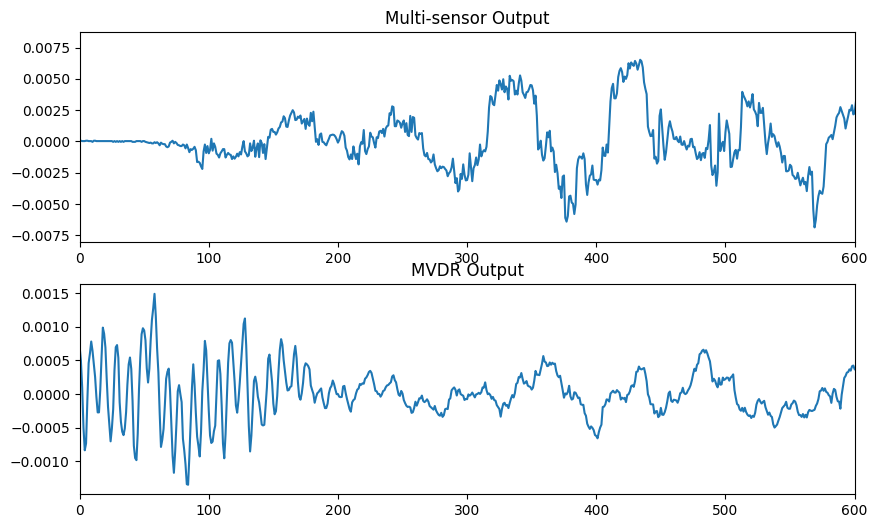

In [267]:
f,ax = plt.subplots(2,1,figsize=(10,6))
#for i in range(M):
   #ax[0].plot(X[i,:])

ax[0].plot(s1)
ax[1].plot(output_signal)


ax[0].set_xlim([0,600])
ax[1].set_xlim([0,600])


ax[0].set_title('Multi-sensor Output')
ax[1].set_title('MVDR Output')